# import Libraries 

In [5]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, classification_report, auc
import seaborn as sns
from sklearn.model_selection import train_test_split

# Import Dataset

In [6]:
!git clone "https://github.com/hmda77/Machine-Learning-Class"
!mv "Machine-Learning-Class"/XGBoost/Titanic3/titanic3.xls ./
!rm -rf "Machine-Learning-Class"

Cloning into 'Machine-Learning-Class'...
remote: Enumerating objects: 163, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 163 (delta 17), reused 3 (delta 3), pack-reused 108
Receiving objects: 100% (163/163), 10.48 MiB | 110.00 KiB/s, done.
Resolving deltas: 100% (41/41), done.


In [7]:
data = pd.read_excel("titanic3.xls")
data.head(5)

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [8]:
data.columns

Index(['pclass', 'survived', 'name', 'sex', 'age', 'sibsp', 'parch', 'ticket',
       'fare', 'cabin', 'embarked', 'boat', 'body', 'home.dest'],
      dtype='object')

# Process On Dataset

## Split Features

In [9]:
X_Train = data.drop('survived', axis = 1)

In [10]:
X_Train.shape

(1309, 13)

### check null cells

In [11]:
X_Train.isnull().sum()

pclass          0
name            0
sex             0
age           263
sibsp           0
parch           0
ticket          0
fare            1
cabin        1014
embarked        2
boat          823
body         1188
home.dest     564
dtype: int64

## Reproduce data for Nulls

### Cabin, Age, Body Combination
Combine this three Features for making new attribute

In [12]:
data.survived.mean()

0.3819709702062643

38% of passengers dead

In [13]:
data.cabin.isnull().mean()

0.774637127578304

77% of all passengers don't have "Cabin" attribiute

In [14]:
(data.cabin.isnull() & (data.survived == 0)).mean()

0.5401069518716578

54% of them didn't survive

In [15]:
data.body.isnull().mean()

0.907563025210084

90% of all passengers don't have "Body" attribiute

In [12]:
(data.body.isnull() & (data.survived == 0)).mean()

0.5255920550038197

52% of them didn't survive

In [16]:
selector = (data.cabin.isnull() & data.age.isnull() & data.body.isnull())
data[selector].survived.mean()

0.2594142259414226

this number shows that we can cobmine this features

In [17]:
X_Train['nulls'] = X_Train.cabin.isnull().astype('int') + X_Train.age.isnull().astype('int') \
                    + X_Train.body.isnull().astype('int')

### map string attribute to number

In [18]:
X_Train['cabin_mapped'] = X_Train['cabin'].astype(str).str[0] # this captures the letter

In [19]:
# this transforms the letters into numbers
cabin_dict = {k:i for i, k in enumerate(X_Train.cabin_mapped.unique())} 
X_Train.loc[:, 'cabin_mapped'] = X_Train.loc[:, 'cabin_mapped'].map(cabin_dict)

/tmp/ipykernel_682/3030243961.py:3: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X_Train.loc[:, 'cabin_mapped'] = X_Train.loc[:, 'cabin_mapped'].map(cabin_dict)


In [20]:
cabin_dict

{'B': 0, 'C': 1, 'E': 2, 'D': 3, 'A': 4, 'n': 5, 'T': 6, 'F': 7, 'G': 8}

In [21]:
X_Train.columns

Index(['pclass', 'name', 'sex', 'age', 'sibsp', 'parch', 'ticket', 'fare',
       'cabin', 'embarked', 'boat', 'body', 'home.dest', 'nulls',
       'cabin_mapped'],
      dtype='object')

In [22]:
X_Train.drop(['age', 'cabin','body'], inplace = True, axis = 1)

In [23]:
X_Train.isnull().sum()

pclass            0
name              0
sex               0
sibsp             0
parch             0
ticket            0
fare              1
embarked          2
boat            823
home.dest       564
nulls             0
cabin_mapped      0
dtype: int64

### fill Null in "Fare"
Consider that dude with Null Fare, is in Pclass 3

In [24]:
fare_mean = X_Train[X_Train.pclass == 3].fare.mean()

In [25]:
X_Train['fare'].fillna(fare_mean, inplace = True)

In [26]:
X_Train.isnull().sum()

pclass            0
name              0
sex               0
sibsp             0
parch             0
ticket            0
fare              0
embarked          2
boat            823
home.dest       564
nulls             0
cabin_mapped      0
dtype: int64

### fill null in "Embarked"

In [27]:
X_Train[X_Train.embarked.isnull()]

,pclass,name,sex,sibsp,parch,ticket,fare,embarked,boat,home.dest,nulls,cabin_mapped
168,1,"Icard, Miss. Amelie",female,0,0,113572,80.0,NaN,6,NaN,1,0
284,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,0,0,113572,80.0,NaN,6,"Cincinatti, OH",1,0


In [28]:
X_Train[X_Train['pclass'] == 1].embarked.value_counts()

S    177
C    141
Q      3
Name: embarked, dtype: int64

In [29]:
X_Train['embarked'].fillna('S', inplace = True)

In [30]:
X_Train.isnull().sum()

pclass            0
name              0
sex               0
sibsp             0
parch             0
ticket            0
fare              0
embarked          0
boat            823
home.dest       564
nulls             0
cabin_mapped      0
dtype: int64

### map string "boat" attribute to number

In [31]:
X_Train['boat_mapped'] = X_Train['boat'].astype(str).str[0] # this captures the letter

In [32]:
# this transforms the letters into numbers
boat_dict = {k:i for i, k in enumerate(X_Train.boat_mapped.unique())} 
X_Train.loc[:, 'boat_mapped'] = X_Train.loc[:, 'boat_mapped'].map(boat_dict)

/tmp/ipykernel_682/1922127723.py:3: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X_Train.loc[:, 'boat_mapped'] = X_Train.loc[:, 'boat_mapped'].map(boat_dict)


In [33]:
boat_dict

{'2': 0,
 '1': 1,
 'n': 2,
 '3': 3,
 'D': 4,
 '4': 5,
 '9': 6,
 '6': 7,
 'B': 8,
 '8': 9,
 'A': 10,
 '5': 11,
 '7': 12,
 'C': 13}

## Drop useless attributes

In [34]:
X_Train.drop(['boat', 'home.dest'], inplace = True, axis = 1)

In [35]:
X_Train.isnull().sum()

pclass          0
name            0
sex             0
sibsp           0
parch           0
ticket          0
fare            0
embarked        0
nulls           0
cabin_mapped    0
boat_mapped     0
dtype: int64

In [39]:
X_Train.drop(['name', 'ticket'], axis = 1, inplace = True)

## Changing Types

In [40]:
X_Train.dtypes

pclass            int64
sex              object
sibsp             int64
parch             int64
fare            float64
embarked         object
nulls             int64
cabin_mapped      int64
boat_mapped       int64
dtype: object

In [41]:
X_dummies = pd.get_dummies(X_Train, columns = ['sex', 'nulls', 'cabin_mapped', 'embarked', 'boat_mapped'],\
                           drop_first= True)

In [42]:
X_dummies.dtypes

pclass              int64
sibsp               int64
parch               int64
fare              float64
sex_male            uint8
nulls_1             uint8
nulls_2             uint8
nulls_3             uint8
cabin_mapped_1      uint8
cabin_mapped_2      uint8
cabin_mapped_3      uint8
cabin_mapped_4      uint8
cabin_mapped_5      uint8
cabin_mapped_6      uint8
cabin_mapped_7      uint8
cabin_mapped_8      uint8
embarked_Q          uint8
embarked_S          uint8
boat_mapped_1       uint8
boat_mapped_2       uint8
boat_mapped_3       uint8
boat_mapped_4       uint8
boat_mapped_5       uint8
boat_mapped_6       uint8
boat_mapped_7       uint8
boat_mapped_8       uint8
boat_mapped_9       uint8
boat_mapped_10      uint8
boat_mapped_11      uint8
boat_mapped_12      uint8
boat_mapped_13      uint8
dtype: object

## Split Train ,Test Data

In [43]:
# split data & label
X_train = X_dummies
Y_train = data.survived

# make Train & validation set
train_set, test_set, train_labels, test_labels = train_test_split(X_train, Y_train, stratify=Y_train,
                                                                      random_state= 231,test_size=0.20)

In [44]:
unique, counts = np.unique(Y_train, return_counts=True)
for i in range(len(unique)):
  print('Survived: {} counts: {}'.format(unique[i],counts[i]))

Survived: 0 counts: 809
Survived: 1 counts: 500


In [45]:
print(train_set.shape,test_set.shape)
print(train_labels.shape,test_labels.shape)

(1047, 31) (262, 31)
(1047,) (262,)


# Train XGBoost Classifier

In [46]:
model = XGBClassifier()
model.fit(train_set, train_labels)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

# Metric Functions

In [47]:
# Make the confusion matrix
def confusion_plot(y_test,y_pred,title):
    cmt = confusion_matrix(y_test,y_pred)
    plt.rcParams['figure.figsize'] = (10,8)
    sns.heatmap(cmt,fmt='',annot=True,linewidth=0.01,cmap=sns.cubehelix_palette(as_cmap=True))
    plt.title("confusion matrix {}".format(title))
    plt.xlabel("predicted")
    plt.ylabel("true")
    plt.show()


# generate classification report
def generate_classification_report(y_test,y_pred):
    report=pd.DataFrame.from_dict(classification_report(y_pred,y_test,output_dict=True)).T
    # report['Label']=[data_classes[i]  if i<5 else " " for i,x in enumerate(report.index)]
    report=report[['f1-score','precision','recall','support']]
    pd.set_option('display.max_rows', report.shape[0]+1)
    return report

# ROC Curve
def plot_roc_curve(y_test,proba,pos_label):
    fpr, tpr, thresholds = roc_curve(y_test, proba[:,pos_label], pos_label= pos_label)
    roc_auc = roc_auc_score(y_test, proba, multi_class='ovr')

    plt.rcParams['figure.figsize'] = (5,4)
    plt.plot(fpr, tpr,'k:',lw=5, label='average ROC curve (area = {0:0.2f})'.format(roc_auc))
    plt.plot([0 ,1],[0 ,1],'r')
    plt.legend(loc="lower right")
    plt.title('ROC Curve for calss {0}'.format(data_classes[pos_label]))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


# ROC Curve for all classes
def plot_roc_curve_all(y_test,proba,n_class,title):
    for i in range(n_class):
      fpr, tpr, thresholds = roc_curve(y_test, proba[:,i],pos_label= i)
      plt.plot(fpr, tpr,lw=1)
    plt.plot([0 ,1],[0 ,1],'r')
    plt.title('ROC Curve for all classes in {}'.format(title))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(data_classes)
    plt.show()

# Predict, Accuracy, Confusion Matrix

In [48]:
y_pred = model.predict(test_set)

In [49]:
generate_classification_report(test_labels, y_pred)

,f1-score,precision,recall,support
0,0.965944,0.962963,0.968944,161.000000
1,0.945274,0.950000,0.940594,101.000000
accuracy,0.958015,0.958015,0.958015,0.958015
macro avg,0.955609,0.956481,0.954769,262.000000
weighted avg,0.957976,0.957966,0.958015,262.000000


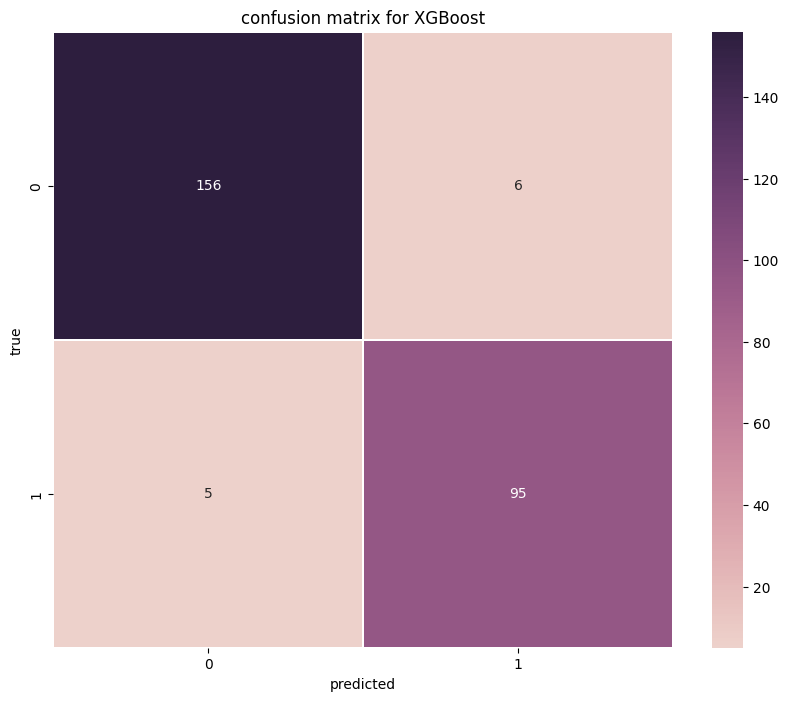

In [50]:
confusion_plot(test_labels,y_pred,'for XGBoost')